In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 64
learning_rate = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 10

In [3]:
transform = transforms.Compose([
    transforms.Resize([227, 227]),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class LocalResponseNorm(nn.Module):
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LocalResponseNorm, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average = nn.AvgPool3d(kernel_size=(local_size, 1, 1),  # 0.2.0_4会报错，需要在最新的分支上AvgPool3d才有padding参数
                                        stride=1,
                                        padding=(int((local_size-1.0)/2), 0, 0))
        else:
            self.average = nn.AvgPool2d(kernel_size=local_size,
                                        stride=1,
                                        padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta

    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)  # 这里的1.0即为bias
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

In [8]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        # input [batch,3,227,227] -> [batch,256,6,6]
        self.num_classes = num_classes
        self.features = nn.Sequential(
            # input [batch,3,227,227] -> [batch,96,55,55]
            nn.Conv2d(in_channels=3, out_channels=96,
                      kernel_size=11, stride=4, padding=0),
            LocalResponseNorm(local_size=5, alpha=1e-4,
                              beta=0.75, ACROSS_CHANNELS=True),
            # input [batch,96,55,55] -> [batch,96,27,27]
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            # input [batch,96,27,27] -> [batch,256,27,27]
            nn.Conv2d(in_channels=96, out_channels=256,
                      kernel_size=5, stride=1, padding=2),
            LocalResponseNorm(local_size=5, alpha=1e-4,
                              beta=0.75, ACROSS_CHANNELS=True),
            # input [batch,256,27,27] -> [batch,256,13,13]
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
            # input [batch,256,13,13] -> [batch,384,13,13]
            nn.Conv2d(in_channels=256, out_channels=384,
                      kernel_size=3, stride=1, padding=1),
            # input [batch,384,13,13] -> [batch,384,13,13]
            nn.Conv2d(in_channels=384, out_channels=384,
                      kernel_size=3, stride=1, padding=1),
            # input [batch,384,13,13] -> [batch,256,13,13]
            nn.Conv2d(in_channels=384, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            # input [batch,256,13,13] -> [batch,256,6,6]
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(6 * 6 * 256, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, self.num_classes),
        )

    def forward(self, x):
        # [batch,3,227,227]
        batch_size = x.size(0)
        # [batch,256,6,6]
        x = self.features(x)
        # [batch,256*6*6]
        x = x.view(batch_size, -1)
        # [batch,10]
        x = self.classifier(x)
        return x

In [9]:
net = AlexNet().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
summary(net, (3, 227, 227))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
         AvgPool3d-2        [-1, 1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
         AvgPool3d-6       [-1, 1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
           Conv2d-10          [-1, 384, 13, 13]       1,327,488
           Conv2d-11          [-1, 256, 13, 13]         884,992
        MaxPool2d-12            [-1, 256, 6, 6]               0
          Dropout-13                 [-1, 9216]               0
           Linear-14                 [-

In [12]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [13]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))

    return val_loss, val_acc

In [14]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [15]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')

    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [16]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')

    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [17]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)

        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.301166
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.214889
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.923725
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.839005
Train Epoch: 1 [25600/40000 (64%)]	Loss: 2.133051
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.411776
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.531726
VAL set: Average loss: 0.024009, Accuracy: 4465.0/10000 (44.6%)
Validation loss decreased (inf --> 0.024009).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.338159
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.745279
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.277694
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.529155
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.404297
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.528433
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.334560
VAL set: Average loss: 0.021681, Accuracy: 5070.0/10000 (50.7%)
Validation loss decreased (0.024009 --> 0.021681).  Saving model ...

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.343212
Trai

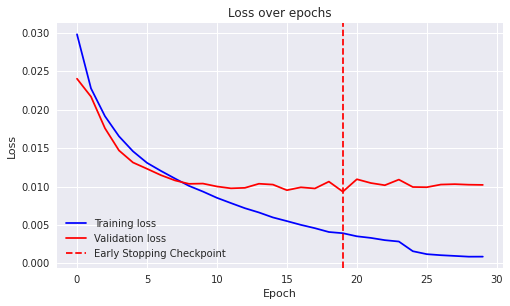

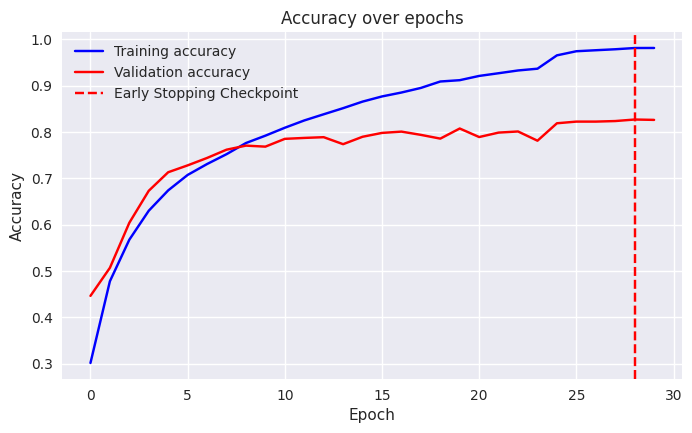

In [18]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'AlexNet - predictions')

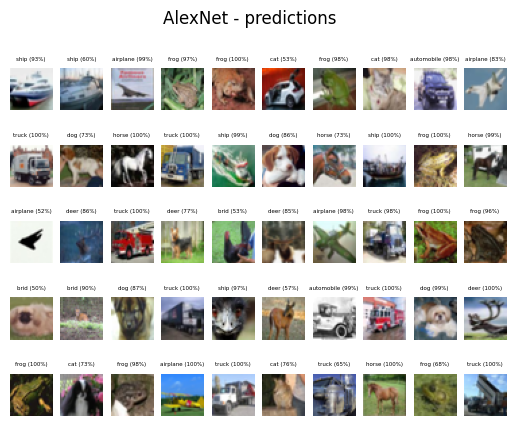

In [19]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('AlexNet - predictions')

In [ ]:
"""
AlexNet
structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 96, 55, 55]          34,944
         AvgPool3d-2        [-1, 1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
         AvgPool3d-6       [-1, 1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
           Conv2d-10          [-1, 384, 13, 13]       1,327,488
           Conv2d-11          [-1, 256, 13, 13]         884,992
        MaxPool2d-12            [-1, 256, 6, 6]               0
          Dropout-13                 [-1, 9216]               0
           Linear-14                 [-1, 4096]      37,752,832
             ReLU-15                 [-1, 4096]               0
          Dropout-16                 [-1, 4096]               0
           Linear-17                 [-1, 4096]      16,781,312
             ReLU-18                 [-1, 4096]               0
           Linear-19                   [-1, 10]          40,970
================================================================
Total params: 58,322,314
Trainable params: 58,322,314
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.59
Forward/backward pass size (MB): 13.40
Params size (MB): 222.48
Estimated Total Size (MB): 236.47
----------------------------------------------------------------
parameters_count: 58322314
"""